## Import libraries 

In [1]:
import pandas as pd
import nltk,re,string
import tensorflow
import keras
from keras.models import Sequential
from sklearn.metrics import accuracy_score,classification_report
from keras.layers import Dense,Dropout
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
import warnings
from keras.models import load_model
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from keras.callbacks import EarlyStopping,ModelCheckpoint
warnings.filterwarnings("ignore", category=RuntimeWarning)

Using TensorFlow backend.


## Read Data

In [2]:
data=pd.read_csv('./SMSCollection.csv',sep='\t',header=None,names=['label','text'])
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print("Out of {} rows ,{} are spam and {} are ham".format(len(data),
                                                          len(data[data['label']=='spam']),
                                                          len(data[data['label']=='ham'])))

Out of 5572 rows ,747 are spam and 4825 are ham


In [4]:
print("Number of null in label is {}".format(data['label'].isnull().sum()))
print("Number of null in text is {}".format(data['text'].isnull().sum()))

Number of null in label is 0
Number of null in text is 0


## Clean data

In [5]:
st=SnowballStemmer('english')
stopword=nltk.corpus.stopwords.words("english")
#function to perform basic cleaning tasks
def preprocess(text):
    text="".join([word.lower() for word in text if word not in string.punctuation])
    tokens=re.split('\W+',text)
    text=[st.stem(word) for word in tokens if word not in stopword]
    return text

## Feature Creation

In [6]:
#using tfidf for vectorizing data
tfidf=TfidfVectorizer(analyzer=preprocess)
x_tfidf=tfidf.fit_transform(data['text'])
#print(tfidf.get_feature_names())

In [7]:
#create features for a % of the text which is punctuation
def count_punct(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100
data['text_len']=data['text'].apply(lambda x:len(x)-x.count(" "))
data['punct%']=data['text'].apply(lambda x:count_punct(x))
xfeatures=pd.concat([data['text_len'],data['punct%'],pd.DataFrame(x_tfidf.toarray())],axis=1)

## Model Creation

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(xfeatures,data['label'],test_size=0.2)

In [9]:
model=Sequential()
model.add(Dense(5,input_dim=8110,activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
new_train=[]
for i in ytrain:#labels_train:
    if i == "ham":
        new_train.append('1')
    else:
        new_train.append('0')

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
ckpt = ModelCheckpoint('best_model_spam.h5', monitor='val_loss', mode='min', save_best_only=True)

history=model.fit(xtrain,pd.Series(new_train),epochs=5,validation_split=0.2, batch_size=10, callbacks=[es,ckpt])
# load the saved model
saved_model = load_model('best_model_spam.h5')

predictions = model.predict(xtest)#(features_test)
#print(predictions)
roundd=[round(i[0]) for i in predictions]
#print(roundd)
new_test=[]
for i in ytest:#labels_test:
    if i == "ham":
        new_test.append(1.0)
    else:
        new_test.append(0.0)

accuracy_score(new_test,roundd)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 40555     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                150       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                650       
________________________________________________

<Figure size 640x480 with 1 Axes>

0.9856502242152466

## Training Visualization and Metrics

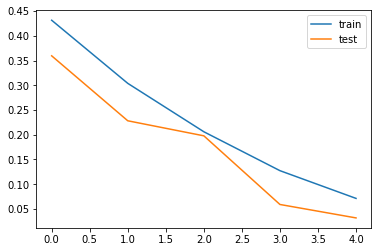

In [11]:
# plot training history
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
print(classification_report(new_test,roundd))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95       152
         1.0       0.99      1.00      0.99       963

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

